In [1]:
import re

import numpy as np
import optuna as opt
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [2]:
random_id = 17 #ai23m017 - 17 is the id
random_state = np.random.RandomState(random_id)

In [3]:
to_test = pd.read_csv("test.csv", index_col="PassengerId")
df = pd.read_csv("train.csv", index_col="PassengerId")
df

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,S


In [4]:
df = df.convert_dtypes()
df["Embarked"] = df["Embarked"].astype("category")
df.dtypes

Survived             Int64
Pclass               Int64
Name        string[python]
Age                Float64
SibSp                Int64
Parch                Int64
Ticket      string[python]
Fare               Float64
Cabin       string[python]
Embarked          category
dtype: object

In [5]:
'''
random_id = 17 #ai23m017 - 17 is the id
# a RandomState object or the id may be used, choose a variant
random_state = np.random.RandomState(random_id)
random_state = random_id
'''
#TODO implement this for all random states

'\nrandom_id = 17 #ai23m017 - 17 is the id\n# a RandomState object or the id may be used, choose a variant\nrandom_state = np.random.RandomState(random_id)\nrandom_state = random_id\n'

In [6]:
X_train,X_test,y_train,y_test = train_test_split(df.drop("Survived", axis=1), df["Survived"], test_size=0.3, random_state=random_id)
print(df.columns[df.isna().any(axis=0)].tolist())

['Age', 'Cabin', 'Embarked']


### Data Pre-Processing after splitting the data to prevent data - leakage

In [7]:
#Data Imputation for the Age column
data = [X_train, X_test, to_test]
for dataset in data:
    mean = X_train["Age"].mean()
    std = X_test["Age"].std()
    is_null = dataset["Age"].isna().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    rand_age_series = pd.Series(rand_age, index=dataset[dataset["Age"].isnull()].index)
    dataset["Age"].fillna(rand_age_series, inplace=True)
    dataset["Age"] = dataset["Age"].astype(int)
    

In [8]:
#Feature Engineering the Deck Column 
#Cabins are mapped to a numerical Deck feature

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

for dataset in data:
    
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
    dataset.drop(["Cabin"], axis=1, inplace=True)

In [9]:
X_train["Embarked"].describe()
for dataset in [X_train, X_test, to_test]:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)


In [10]:
X_train.isna().any()

Pclass      False
Name        False
Age         False
SibSp       False
Parch       False
Ticket      False
Fare        False
Embarked    False
Deck        False
dtype: bool

In [11]:
#Feature Engineering Title Column
status_map={'Capt':'Military',
            'Col':'Military',
            'Don':'Noble',
            'Dona':'Noble',
            'Dr':'Dr',
            'Jonkheer':'Noble',
            'Lady':'Noble',
            'Major':'Military',
            'Master':'Common',
            'Miss':'Common',
            'Mlle':'Common',
            'Mme':'Common',
            'Mr':'Common',
            'Mrs':'Common',
            'Ms':'Common',
            'Rev':'Clergy',
            'Sir':'Noble',
            'the Countess':'Noble',
            }

for dataset in data:
    dataset["Title"] = dataset["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
    print(pd.unique(X_train["Title"]))
    #dataset['Social_Status'] = dataset['Title'].map(status_map)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


['Mrs' 'Miss' 'Mr' 'Master' 'Rev' 'Dr' 'Jonkheer' 'Mlle' 'Sir' 'Ms' 'Capt'
 'Major' 'Don']
['Mrs' 'Miss' 'Mr' 'Master' 'Rare']
['Mrs' 'Miss' 'Mr' 'Master' 'Rare']


In [12]:
#Feature Engineering Sex Column 
def map_to_sex(value):
    if value in ["Miss","Mrs"]:
        return "female"
    else:
        return "male"

for dataset in data:
    dataset["Sex"] = dataset["Title"].apply(map_to_sex)
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    #dataset.drop("Title", axis=1, inplace=True)

In [13]:
#Feature Engineering Family Size Column
for dataset in data:
    dataset["Fam_size"] = dataset["SibSp"] + dataset["Parch"] + 1
    dataset["Fam_type"] = pd.cut(dataset.Fam_size, [0,1,4,7,11], labels=["Solo", "Small", "Big", "Very big"])
    dataset['IsAlone'] = 0
    dataset.loc[dataset['Fam_size'] == 1, 'IsAlone'] = 1
    dataset.drop(["SibSp","Parch"], axis=1, inplace=True)


In [14]:
X_train

,Pclass,Name,Age,Ticket,Fare,Embarked,Deck,Title,Sex,Fam_size,Fam_type,IsAlone
PassengerId,,,,,,,,,,,,
67,2,"Nye, Mrs. (Elizabeth Ramell)",29,C.A. 29395,10.5,S,6,Mrs,1,1,Solo,1
382,3,"Nakid, Miss. Maria (""Mary"")",1,2653,15.7417,C,8,Miss,1,3,Small,0
224,3,"Nenkoff, Mr. Christo",18,349234,7.8958,S,8,Mr,0,1,Solo,1
630,3,"O'Connell, Mr. Patrick D",28,334912,7.7333,Q,8,Mr,0,1,Solo,1
338,1,"Burns, Miss. Elizabeth Margaret",41,16966,134.5,C,5,Miss,1,1,Solo,1
...,...,...,...,...,...,...,...,...,...,...,...,...
407,3,"Widegren, Mr. Carl/Charles Peter",51,347064,7.75,S,8,Mr,0,1,Solo,1
391,1,"Carter, Mr. William Ernest",36,113760,120.0,S,2,Mr,0,4,Small,0
144,3,"Burke, Mr. Jeremiah",19,365222,6.75,Q,8,Mr,0,1,Solo,1


In [15]:
for dataset in data:
    ticket_frequency = dataset.groupby('Ticket')['Name'].transform('count')
    #dataset['Ticket_Frequency'] = ticket_frequency

In [16]:

for dataset in data:
    dataset['Age*Class'] = dataset['Age'] * dataset['Pclass']
    dataset.drop(columns=["Age","Pclass"], inplace=True)
    

In [17]:
for dataset in data:
    dataset['Fare'] = np.log1p(dataset['Fare'])
    dataset['Fare_Per_Person'] = dataset['Fare'] / (dataset['Fam_size'])
    #dataset['Fare_Bin'] = pd.qcut(dataset['Fare'], 4, labels=False)
    
    dataset.drop(columns=["Fare","Name","Fam_size","Ticket"], axis=1, inplace=True)

In [18]:
X_train

,Embarked,Deck,Title,Sex,Fam_type,IsAlone,Age*Class,Fare_Per_Person
PassengerId,,,,,,,,
67,S,6,Mrs,1,Solo,1,58,2.442347
382,C,8,Miss,1,Small,0,3,0.939301
224,S,8,Mr,0,Solo,1,54,2.185579
630,Q,8,Mr,0,Solo,1,84,2.167143
338,C,5,Miss,1,Solo,1,41,4.908972
...,...,...,...,...,...,...,...,...
407,S,8,Mr,0,Solo,1,153,2.169054
391,S,2,Mr,0,Small,0,36,1.198948
144,Q,8,Mr,0,Solo,1,57,2.047693


### Encode all Labels to String in order to pass through the GBM model

In [19]:
X_train = X_train.apply(LabelEncoder().fit_transform)
X_test = X_test.apply(LabelEncoder().fit_transform)
to_test = to_test.apply(LabelEncoder().fit_transform)
X_train

,Embarked,Deck,Title,Sex,Fam_type,IsAlone,Age*Class,Fare_Per_Person
PassengerId,,,,,,,,
67,2,5,3,1,2,1,52,179
382,0,7,1,1,1,0,2,31
224,2,7,2,0,2,1,48,148
630,1,7,2,0,2,1,70,135
338,0,4,1,1,2,1,35,247
...,...,...,...,...,...,...,...,...
407,2,7,2,0,2,1,97,137
391,2,1,2,0,1,0,30,61
144,1,7,2,0,2,1,51,112


### Cross-Fold Validation

In [20]:
xgb_classifier = XGBClassifier() # classifier used to tune hyperparameters

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # More conservative learning rate
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),  # Fewer estimators
        'max_depth': trial.suggest_int('max_depth', 3, 7),  # Shallower trees
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),  # Less aggressive subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),  # Feature subsampling
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),  # Additional regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),  # More range for L1 regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),  # More range for L2 regularization
    }

    model = xgb.XGBClassifier(**param)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Ensuring reproducibility
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()


In [21]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-03-18 01:08:27,206] A new study created in memory with name: no-name-9b226244-f26c-4b22-bfcd-0a0ae7a99ab2
C:\Users\dlesha\AppData\Local\Temp\ipykernel_13400\2903819095.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),  # More range for L1 regularization
C:\Users\dlesha\AppData\Local\Temp\ipykernel_13400\2903819095.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),  # More range for L2 regularization
[I 2024-03-18 01:08:29,777] Trial 0 finished with value: 0.8089806451612903 and parameters: {'learning_rate': 0.15140206800105233, '

Number of finished trials: 50
Best trial: {'learning_rate': 0.051135824507311564, 'n_estimators': 599, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5508118241804579, 'colsample_bytree': 0.6118443799740958, 'gamma': 4.533873626510567, 'reg_alpha': 0.06060906459420002, 'reg_lambda': 0.6809976304140697}


In [23]:
best_trial = study.best_trial
print(f"Best trial accuracy: {best_trial.value}")

Best trial accuracy: 0.8395225806451613


### Generate Results

In [24]:
xgb_classifier.set_params(**best_trial.params)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6118443799740958, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.533873626510567, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.051135824507311564, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=599, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [64]:
y_pred = xgb_classifier.predict(X_test)

In [65]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


In [66]:
submission_test = xgb_classifier.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
# save submission
submission_test.to_csv('submission_test_xgb.csv') 

In [67]:
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId', suffixes=('_df1', '_df2'))
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.7763819095477387


In [38]:
merged_df

,survived,Survived
PassengerId,,
892,0.0,0
892,0.0,0
893,1.0,0
894,0.0,0
895,0.0,0
...,...,...
1305,0.0,0
1306,1.0,1
1307,0.0,0


In [39]:
results = permutation_importance(xgb_classifier, X_test, y_test, scoring='accuracy')
results

{'importances_mean': array([0.0119403 , 0.01268657, 0.04029851, 0.10074627, 0.00820896,
        0.        , 0.03656716, 0.03208955]),
 'importances_std': array([0.00435146, 0.00506144, 0.00597015, 0.00973015, 0.00279228,
        0.        , 0.00279228, 0.00768331]),
 'importances': array([[0.01119403, 0.00373134, 0.01492537, 0.01492537, 0.01492537],
        [0.01119403, 0.02238806, 0.01119403, 0.01119403, 0.00746269],
        [0.03731343, 0.04477612, 0.02985075, 0.04477612, 0.04477612],
        [0.11567164, 0.10074627, 0.10447761, 0.0858209 , 0.09701493],
        [0.01119403, 0.00746269, 0.00746269, 0.00373134, 0.01119403],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.03731343, 0.03358209, 0.03358209, 0.04104478, 0.03731343],
        [0.03731343, 0.03358209, 0.04104478, 0.02985075, 0.01865672]])}

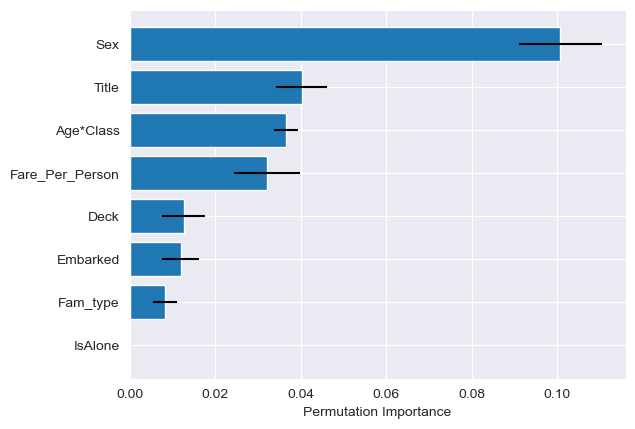

In [41]:
importance = results.importances_mean
std = results.importances_std

features = X_train.columns
sorted_idx = importance.argsort()

plt.barh(range(len(sorted_idx)), importance[sorted_idx], xerr=std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

## DecisionTree

## RandomForestClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier


def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestClassifier(**param, random_state=random_id)
    
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return scores.mean()

In [43]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print(f"Best trial accuracy: {study.best_trial.value}")

[I 2024-03-18 01:59:45,300] A new study created in memory with name: no-name-4170b7ec-6925-47f0-a25a-0851612faf66
[I 2024-03-18 01:59:50,922] Trial 0 finished with value: 0.8378322580645161 and parameters: {'n_estimators': 883, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8378322580645161.
[I 2024-03-18 01:59:55,099] Trial 1 finished with value: 0.7752516129032259 and parameters: {'n_estimators': 489, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8378322580645161.
[I 2024-03-18 01:59:58,933] Trial 2 finished with value: 0.8234064516129033 and parameters: {'n_estimators': 940, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8378322580645161.
[I 2024-03-18 01:59:59,922] Trial 3 finished with value: 0.8442451612903227 an

Number of finished trials: 30
Best trial: {'n_estimators': 336, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Best trial accuracy: 0.8474580645161292


In [44]:
randomForest_classifier = RandomForestClassifier()
randomForest_classifier.set_params(**study.best_trial.params)
randomForest_classifier.fit(X_train, y_train)
y_pred = randomForest_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


### Compare accuracy to supposed real data

In [45]:
submission_test = randomForest_classifier.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId', suffixes=('_df1', '_df2'))
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")


Accuracy Score: 0.7788944723618091


In [46]:
#submission_test.to_csv("submission_test_randomForest_3.csv")

In [47]:
to_test.columns

Index(['Embarked', 'Deck', 'Title', 'Sex', 'Fam_type', 'IsAlone', 'Age*Class',
       'Fare_Per_Person'],
      dtype='object')

### Try out ensemble of different models

In [60]:
stacking_clf = StackingClassifier(
    estimators=[('rf', randomForest_classifier), ('xgb', xgb_classifier)],
    final_estimator=LogisticRegression(),
    stack_method='auto',
    cv=10
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=6,
                                                       min_samples_split=7,
                                                       n_estimators=336)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6118443799740958,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              fe...
                                              interaction_constraints=None,
                                              learning_rate=0.051135824507311564,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=599, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [61]:
accuracy = stacking_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7947761194029851


In [62]:
submission_test = stacking_clf.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId')
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.7814070351758794


In [63]:
submission_test.to_csv("submission_test_ensemble.csv")

In [52]:
X_train.columns.to_list()

['Embarked',
 'Deck',
 'Title',
 'Sex',
 'Fam_type',
 'IsAlone',
 'Age*Class',
 'Fare_Per_Person']